In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import random
from dataset import *
import gc
from model import *

In [ ]:
class Args:
    def __init__(self):
        self.gpu = 1
        self.run_label = 0
        self.feat_size = 128
        self.batch_size = 8
        self.q_learning_rate = 1e-2
        self.n_sample = 1024
        self.n_future = 10
        self.n_past = 2
        self.predictor_model = 'big'
        self.log_root = '/data/hdim-forecast/log3'
        
args = Args()
device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [ ]:
while True:
    args.name = 'pred=%s-seq=%d/%d-ns=%d-feat_size=%d-bs=%d-qlr=%.5f-run=%d' % \
        (args.predictor_model, args.n_past, args.n_future, args.n_sample, args.feat_size, 
         args.batch_size, args.q_learning_rate, args.run_label)
    args.log_dir = os.path.join(self.log_root, args.name)
    if not os.path.isdir(args.log_dir):
        os.makedirs(args.log_dir)
        break
    args.run_label += 1
print("Run number = %d" % args.run_label)
writer = SummaryWriter(args.log_dir)
log_writer = open(os.path.join(args.log_dir, 'results.txt'), 'w')

start_time = time.time()
global_iteration = 0
random.seed(args.run_label)  # Set a different random seed for different run labels
torch.manual_seed(args.run_label)
    
def log_scalar(name, value, epoch):
    writer.add_scalar(name, value, epoch)
    log_writer.write('%f ' % value)
    
def message(epoch):
    print("Finished epoch %d, time elapsed %.1f" % (epoch, time.time() - start_time))

In [ ]:
feat_model = FeatureNetC(args.feat_size)
feat_model.load_state_dict(torch.load('pretrained/representation-c-%d.pt' % args.feat_size), strict=False)
feat_model = feat_model.to(device)
feat_model.eval()

In [ ]:
multi_dataset = MovingMNISTMulti(train=True, n_past=args.n_past, n_future=args.n_future, n_sample=args.n_sample, deterministic=False, last_only=True)
multi_loader = DataLoader(multi_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)

In [ ]:
predictor = predictors[args.predictor_model](args.feat_size).to(device)

In [ ]:
predictor.load_state_dict(torch.load('pretrained/predictor_128-10-big.pt'))

In [ ]:
# Design a set of query functions, each query function should be a map from [batch_size, 1, 64, 64] tensor into a real number
intensity = [
    lambda x: x[:, 0, :32, :].mean(dim=(1, 2)) - x[:, 0, 32:, :].mean(dim=(1, 2)),
    lambda x: x[:, 0, :, :32].mean(dim=(1, 2)) - x[:, 0, :, 32:].mean(dim=(1, 2))
]

def get_func(left, right): 
    return lambda x: x[:, 0, left:left+32, right:right+32].mean(dim=(1, 2)) 
    
has_digit = [get_func(left, right) for left in [0, 16, 32] for right in [0, 16, 32]]

queries_all = intensity + has_digit

In [ ]:
sampler = Sampler(device=device, batch_size=args.batch_size)

In [21]:
mb_size = 16
assert args.n_sample % mb_size == 0
err_sim = []
err_combo = []
err_feat = []

arr_sim, arr_pred, arr_pred_true, arr_residue, arr_residue_true = [], [], [], [], []

for idx, data in enumerate(multi_loader):
    bx, by, bl = data
    bx = bx.to(device).permute(1, 0, 2, 3, 4, 5)
    # print(bx.shape)
    with torch.no_grad():
        # Run the simulation over multiple batches to avoid memory overflow
        sim_bx = torch.zeros((args.n_sample, args.batch_size, 1, 64, 64)).to(device)
        sim_feat = torch.zeros((args.n_sample, args.batch_size, args.feat_size)).to(device)
        true_feat = torch.zeros((args.n_sample, args.batch_size, args.feat_size)).to(device)
        for rep in range(args.n_sample // mb_size):
            bx_in = bx[0, :, :2].to(device).permute(1, 0, 2, 3, 4)
            # print(bx_in.shape)
            sim_bx[rep*mb_size:(rep+1)*mb_size] = sampler.simulate(bx_in, n_sample=mb_size, n_future=args.n_future)[:, -1]
            # print(simulated_bx.shape)
            sim_feat[rep*mb_size:(rep+1)*mb_size] = feat_model(sim_bx[rep*mb_size:(rep+1)*mb_size].reshape(-1, 1, 64, 64)).view(
                mb_size, args.batch_size, args.feat_size)
            # print(feat.shape)
            bx_in = bx[rep*mb_size:(rep+1)*mb_size, :, -1].reshape(-1, 1, 64, 64)
            # print(bx_in.shape)
            true_feat[rep*mb_size:(rep+1)*mb_size] = feat_model(bx_in).view(mb_size, args.batch_size, args.feat_size)
            #    args.mbatch_size, mb_size, args.feat_size)
            # Warning: to check that these reshapes didn't mess up ordering
    for q_index, query in enumerate(queries_all):
        alpha = torch.randn([1, args.batch_size, args.feat_size], requires_grad=True, device=device)
        alpha_optim = optim.Adam([alpha], lr=args.q_learning_rate)

        sim_val = query(sim_bx.reshape(-1, 1, 64, 64)).view(args.n_sample, args.batch_size)

        for qiter in range(5000):
            alpha_optim.zero_grad()
            loss_q = (sim_val - (sim_feat * alpha).mean(dim=2)).abs().mean()
            # print(query(bx[:, 10]))
            # print((feat_model(bx[:, 10]) * alpha).mean(dim=1))
            loss_q.backward()
            alpha_optim.step()
            writer.add_scalar('loss_q_%d' % q_index, loss_q, qiter)

        # Compute the expectation if we were to use the simulated data only
        with torch.no_grad():
            # Expectation according to future simulations
            sim_exp = sim_val.mean(dim=0)
            # print(sim_exp.shape)
            # Expectation of the features
            # print(predictor(bx[0, :, 0:2]).shape)
            pred_exp_feat = (predictor(bx[0, :, 0:2]) * alpha[0]).mean(dim=1)
            residue_exp = (sim_val - (sim_feat * alpha).mean(dim=2)).mean(dim=0)
            combo_exp = pred_exp_feat + residue_exp

            true_exp = query(bx[:, :, -1].reshape(-1, 1, 64, 64)).view(args.n_sample, args.batch_size).mean(dim=0)
            true_exp_feat = (true_feat.mean(dim=0) * alpha[0]).mean(dim=1)
            true_exp_residue = true_exp - true_exp_feat 
            
            err_sim.append(sim_exp - true_exp)
            err_combo.append(combo_exp - true_exp)
            err_feat.append(pred_exp_feat - true_exp_feat)
            
            arr_residue.append(residue_exp)
            arr_pred.append(pred_exp_feat)
            arr_sim.append(sim_exp)
            arr_pred_true.append(true_exp_feat)
            arr_residue_true.append(true_exp_residue)
            
    message(idx)
    global_iteration += 1


Finished epoch 382, time elapsed 46865.7


KeyboardInterrupt: 

In [22]:
err_sim = torch.cat(err_sim).cpu().numpy()
err_combo = torch.cat(err_combo).cpu().numpy()
err_feat = torch.cat(err_feat).cpu().numpy()

In [23]:
arr_residue = torch.cat(arr_residue).cpu().numpy()
arr_pred = torch.cat(arr_pred).cpu().numpy()
arr_pred_true = torch.cat(arr_pred_true).cpu().numpy()
arr_sim = torch.cat(arr_sim).cpu().numpy()
arr_residue_true = torch.cat(arr_residue_true).cpu().numpy()

In [36]:
print(np.mean(np.abs(err_sim)), np.mean(np.abs(err_combo)), np.mean(np.abs(err_pred)))

0.051168755 0.022871403 0.02296032


In [35]:
err_combo_alt = (arr_residue_true - arr_residue) + (arr_pred_true - arr_pred) 
err_pred = (arr_pred_true + arr_residue_true) - arr_pred

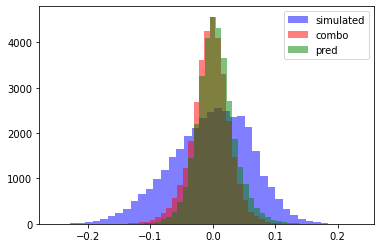

In [34]:
plt.hist(err_sim, bins=40, alpha=0.5, color='b', label='simulated')
plt.hist(err_combo, bins=40, alpha=0.5, color='r', label='combo')
plt.hist(, bins=40, color='g', alpha=0.5, label='pred')
# plt.hist(err_combo_alt, bins=40, alpha=0.5, color='g', label='')
plt.legend()
plt.show()

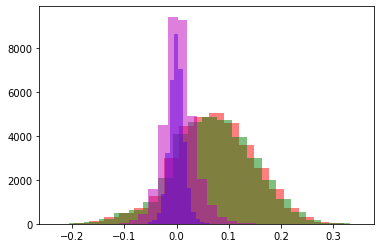

In [28]:
# plt.hist(arr_residue.cpu().numpy(), bins=20, alpha=0.5)
plt.hist(arr_pred, bins=40, alpha=0.5, color='r')
plt.hist(arr_pred_true, bins=40, alpha=0.5, color='g')
plt.hist(arr_pred - arr_pred_true, bins=40, alpha=0.5, color='b')

plt.hist(arr_residue_true, bins=40, alpha=0.5, color='m')
plt.show()

In [ ]:
import seaborn as sns
multi_dataset.set_nsample(args.n_sample)
plt.figure(figsize=(20, 20))
palette = sns.color_palette('hls', 5)
with torch.no_grad():
    for idx, data in enumerate(multi_loader):
        bx, by, bl = data
        bx = bx.to(device)

        actual_feat = feat_model(bx[:, :, -1].view(-1, 1, 64, 64)).view(8, args.n_sample, args.feat_size)
        actual_exp = actual_feat.mean(dim=1)
        pred_exp = predictor(bx[:, 0, 0:2])
        
        for i in range(36):
            plt.subplot(6, 6, i+1)
            plt.hist(actual_feat[0, :, i].cpu().numpy(), bins=20, color=palette[idx], alpha=0.5)
            plt.axvline(pred_exp[0, i], color=palette[idx])
            plt.axvline(actual_exp[0, i], color=palette[idx], linestyle=':')
        if idx == 4:
            break
plt.show()